# **Business Objective: Predicting Health Insurance Premiums**

#### Various factors drive health insurance premiums year-to-year. For example, in 2020 thus far, the COVID-19 pandemic has resulted in a dramatic increase in hospitalizations and supplanted demand for other medical services, such as office visits and non-emergency hospital services, partly due to non-COVID patients' fears of contracting the virus. Consequently, the pandemic has upended the status quo and is a major consideration when setting rates for 2021. Other factors for setting rates include downstream COVID-19 effects, such as shifts in insurance enrollment as more people become unemployed and seek personal health coverage, mental health (stress, depression) and substance abuse treatment needs, and the sudden rise of telehealth/telemedicine as a consequence of stay-at-home orders. Insurance companies use these data to calculate premium costs. Here, we predict the insurance premium costs using common data on age, gender, bmi, number of children, smoker or not, and U.S. region. Analysis was done using **Multiple Linear Regression, K-Nearest Neighbor, Random Forest Regression, and XGBoost Regression**. Models were compared for accuracy.

## Import the libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import the dataset

Please go [here](https://www.kaggle.com/noordeen/insurance-premium-prediction) for the dataset description

In [ ]:
insurance = pd.read_csv('insurance.csv')

X_ins = insurance.iloc[:, :6].values
y = insurance.iloc[:, 6].values

In [ ]:
insurance.shape

(1338, 7)

In [ ]:
insurance.head(20)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


## ***Exploratory Data Analysis***

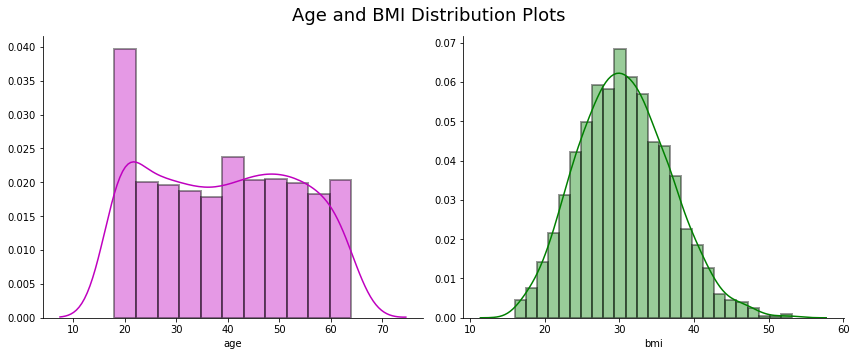

In [ ]:
f, axes = plt.subplots(1,2, figsize=(12, 5))
sns.distplot(insurance['age'], hist_kws=dict(edgecolor="k", linewidth=2), color="m", ax=axes[0])
sns.distplot(insurance['bmi'], hist_kws=dict(edgecolor="k", linewidth=2), color="g", ax=axes[1])

sns.despine(top=True, right=True)
plt.suptitle('Age and BMI Distribution Plots', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.9)

BMI has a normal distribution, while age seems to show a uniform distribution, with the exception of the youngest age range.

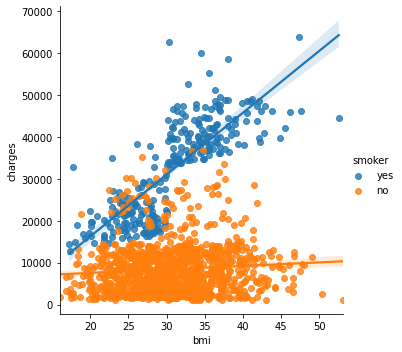

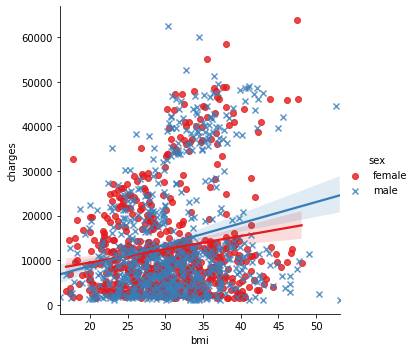

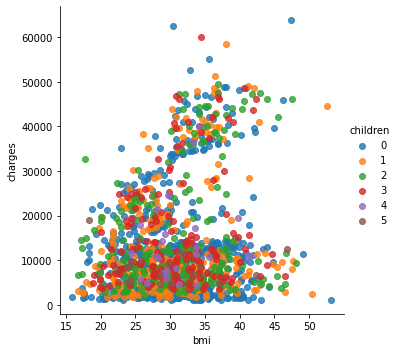

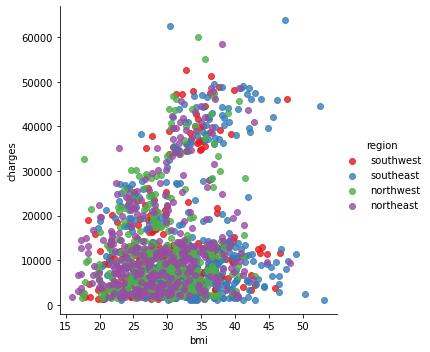

In [ ]:
sns.lmplot(x='bmi', y='charges', hue='smoker', data=insurance)
sns.lmplot(x='bmi', y='charges', hue='sex', palette='Set1', markers=['o', 'x'], data=insurance)
sns.lmplot(x='bmi', y='charges', hue='children', data=insurance, fit_reg=False)
sns.lmplot(x='bmi', y='charges', hue='region', palette='Set1', data=insurance, fit_reg=False)

**Comparison of 'Charges vs. BMI' plots show a clear separation of 'Smoker' vs. 'Non-smoker' subpopulations, with insurance premium rising more dramatically as BMI increases in Smokers. All other categorical subpopulations ('Sex', 'Children', 'Region') show no distinguishable separation.**

**Let's take a look at 'Charges vs. Age'.**

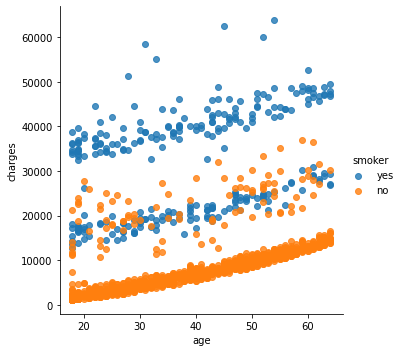

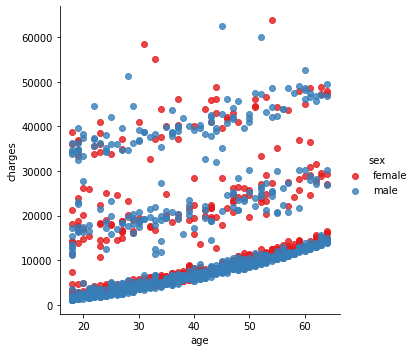

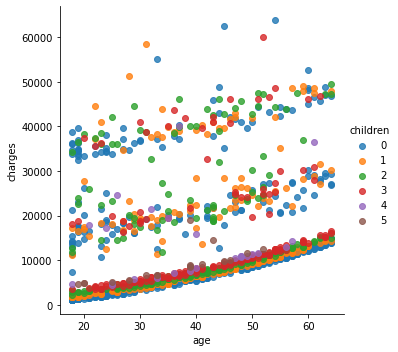

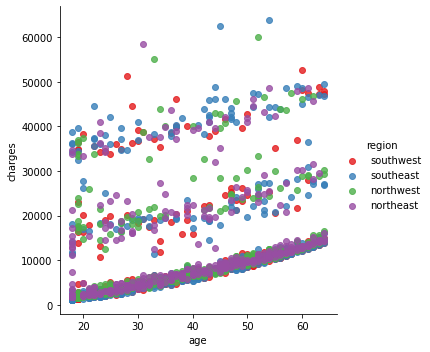

In [ ]:
sns.lmplot(x='age', y='charges', hue='smoker', data=insurance, fit_reg=False)
sns.lmplot(x='age', y='charges', hue='sex', palette='Set1', data=insurance, fit_reg=False)
sns.lmplot(x='age', y='charges', hue='children', data=insurance, fit_reg=False)
sns.lmplot(x='age', y='charges', hue='region', palette='Set1', data=insurance, fit_reg=False)

**Comparison of 'Charges vs. Age' plots show a clear separation of 'Smoker' vs. 'Non-smoker' subpopulations in the top ('Smokers') and bottom ('Non-smokers') tier charges. Not surprisingly, smokers have higher premiums vs. non-smokers, and insurance premiums increase with age. A mix of 'Smokers' and 'Non-smokers' present in the middle tier charges most likely represents the intersection of non-smokers with underlying conditions and 'healthy' smokers with no or nominal underlying conditions. The top-tier charges represent smokers with (presumably) definitive underlying conditions. All other categorical subpopulations ('Sex', 'Children', 'Region') show no distinguishable separation.**

**In general, smoking seems to be a very significant factor in setting insurance premiums.**

## ***Data preprocessing***

## Check for Null Values

In [ ]:
null_count = insurance.isnull().sum()
null_pct = ((insurance.isnull().sum())/(insurance.isnull().count()))*100
null_type = insurance.dtypes
missing_data = pd.concat([null_count, null_pct, null_type], axis = 1, keys = ['Null Values', 'Percent of Total', 'Data Type'])
missing_data = missing_data.sort_values(by = 'Percent of Total', ascending = False).round(2)
missing_data

,Null Values,Percent of Total,Data Type
age,0,0.0,int64
sex,0,0.0,object
bmi,0,0.0,float64
children,0,0.0,int64
smoker,0,0.0,object
region,0,0.0,object
charges,0,0.0,float64


No null values in dataset

## Bin 'age' feature

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer  
kbda = KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='quantile')
X_age = insurance.iloc[:,0].values
X_age_kbda = kbda.fit_transform(X_age.reshape(-1,1))

## Bin 'bmi' feature

In [ ]:
kbdb = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
X_bmi = insurance.iloc[:,2].values
X_bmi_kbdb = kbdb.fit_transform(X_bmi.reshape(-1,1))

Binning increases the performance (accuracy) of some machine learning models. In this project, binning increases the performance of the Multiple Linear Regression model. Binning also reduces overfitting of the Training set in the K-Nearest Neighbor model.

## Encode categorical data

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# OrdinalEncode 'sex' and 'smoker' columns with 1's and 0's
ct_oe = ColumnTransformer(transformers=[('encoder1', OrdinalEncoder(), [1,4])], remainder='passthrough')
X_ins_cat = np.array(ct_oe.fit_transform(X_ins))

# OneHotEncode 'region' column
ct_ohe = ColumnTransformer(transformers=[('encoder2', OneHotEncoder(sparse=False), [5])], remainder='passthrough')
X_ins_cat = np.array(ct_ohe.fit_transform(X_ins_cat))

In [ ]:
# Get rid of the original age and append the binned version to the end of the dataset
X_ins_cat = np.delete(X_ins_cat, 6, axis=1)
X_ins_cat = np.append(X_ins_cat, X_age_kbda, axis=1)

# Get rid of the original bmi and append the binned version to the end of the dataset
X_ins_cat = np.delete(X_ins_cat, 6, axis=1)
X_ins_cat = np.append(X_ins_cat, X_bmi_kbdb, axis=1)

## *Multiple Linear Regression with Feature Selection*

## Split the Insurance dataset into the Training set and Test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_ins_cat, y, test_size = 0.2, random_state = 42)

## Feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

## Linear Regression Model

In [ ]:
from sklearn.linear_model import LinearRegression
lreg = LinearRegression()

## Feature Selection - LassoCV

### Lasso and Cross-Validated Selection Method
- Filter-based feature selection that scores each feature and selects the features with the largest score
- Internally chooses a set of alphas through cross-validation and searches the 'ideal' alpha value by scoring the resulting predictions
- The higher the alpha, the more feature coefficients are zero

Text(0.5, 0, 'Relative Importance')

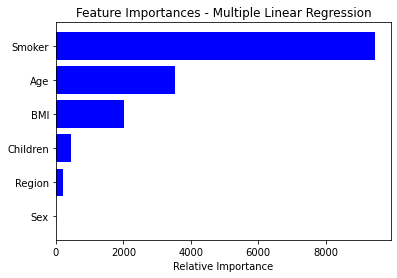

In [ ]:
from sklearn.linear_model import LassoCV
ins_cat = ['Region', 'Sex', 'Smoker', 'Children', 'Age', 'BMI']
reg = LassoCV().fit(X_train_sc, y_train)
importance = np.abs(reg.coef_)

# Sum Coef's for region
feat_region = importance[0:4].sum()

feat_rest = importance[4:]
feat_ins = np.append(feat_region, feat_rest)

indices = np.argsort(feat_ins)
plt.title('Feature Importances - Multiple Linear Regression')
plt.barh(range(len(indices)), feat_ins[indices], color='b', align='center')
plt.yticks(range(len(indices)), np.array(ins_cat)[indices])
plt.xlabel('Relative Importance')

The highest Feature Importance by far belongs to 'Smoker' followed by 'Age' and 'BMI'.

## Update Features in X_train, X_test

In [ ]:
X_train_lreg = np.delete(X_train_sc, [4], axis=1)
X_test_lreg = np.delete(X_test_sc, [4], axis=1)

## Fit the Model on the Train set and Predict the Test set Results

In [ ]:
lreg.fit(X_train_lreg, y_train)
y_pred_lreg = lreg.predict(X_test_lreg)

## Evaluate the Performance

In [ ]:
print("Train score:")
print(round(lreg.score(X_train_lreg, y_train), 5))

train_score = []
train_score.append(round(lreg.score(X_train_lreg, y_train), 5))

Train score:
0.74143


In [ ]:
from sklearn.model_selection import cross_validate
scores = cross_validate(lreg, X_train_lreg, y_train,
                        scoring = 'neg_mean_absolute_error', cv = 10,
                        return_train_score = True, 
                        return_estimator = True)

print('On average, the insurance premium prediction from the Multiple Linear Regression Model is off by ${:,} per person in the Test set.'.format(round(-scores['test_score'].mean(),2)))

off_target = []
off_target.append(round(-scores['test_score'].mean(),0))

On average, the insurance premium prediction from the Multiple Linear Regression Model is off by $4,279.47 per person in the Test set.


In [ ]:
from sklearn.metrics import r2_score
print('R^2 for Predicted vs Actual Insurance Premium:')
print(round(r2_score(y_test, y_pred_lreg),5))

r_square = []
r_square.append(round(r2_score(y_test, y_pred_lreg),5))

R^2 for Predicted vs Actual Insurance Premium:
0.78682


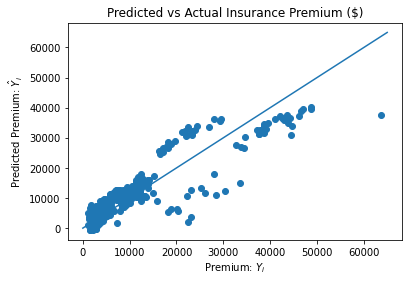

In [ ]:
plt.scatter(y_test, y_pred_lreg)
plt.plot(range(65000), range(65000))

plt.xlabel("Premium: $Y_i$")
plt.ylabel("Predicted Premium: $\hat{Y}_i$")
plt.title("Predicted vs Actual Insurance Premium ($)")

plt.show()

In [ ]:
from sklearn import metrics
print('Insurance Premium - Multiple Linear Regression')
print('Mean Absolute Error (MAE): ${:,}'.format(round(metrics.mean_absolute_error(y_test, y_pred_lreg), 2)))
print('Root Mean Squared Error (RMSE): ${:,}'.format(round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_lreg)), 2)))

rmse = []
rmse.append(round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_lreg)), 2))

Insurance Premium - Multiple Linear Regression
Mean Absolute Error (MAE): $4,192.35
Root Mean Squared Error (RMSE): $5,752.87


## *K-Nearest Neighbor*
- Based on Euclidean distance - similar data points are close to each other, close to the mode of a particular K label for regression
- Number of K labels chosen to reduce the number of errors while maintaining prediction accuracy

## Hypertune KNN parameters

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, GridSearchCV
knn = KNeighborsRegressor()
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

# Define the candidate hyperparameters
hp_select = [{'n_neighbors': [1,2,3,4,5,6], 'weights': ['uniform','distance']}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=knn, param_grid=hp_select, cv=kfold, scoring='r2')
grid.fit(X_train_sc, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

### Best parameters

In [ ]:
print('Best score: {}'.format(grid.best_score_))
print('Best estimator: {}'.format(grid.best_estimator_))
print('Best parameters: {}'.format(grid.best_params_))

Best score: 0.7772179304317857
Best estimator: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                    weights='uniform')
Best parameters: {'n_neighbors': 6, 'weights': 'uniform'}


## Train the K-Nearest Neighbor model on the Training set

In [ ]:
knn_reg = KNeighborsRegressor(n_neighbors = 6, weights = 'uniform', metric = 'minkowski', p = 2)
knn_reg.fit(X_train_sc, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                    weights='uniform')

## Predict the Test set Result

In [ ]:
y_pred_knn = knn_reg.predict(X_test_sc)

## Evaluate the Performance

In [ ]:
print("Train score:")
print(round(knn_reg.score(X_train_sc, y_train), 5))

train_score.append(round(knn_reg.score(X_train_sc, y_train), 5))

Train score:
0.85833


In [ ]:
from sklearn.model_selection import cross_validate
scores = cross_validate(knn_reg, X_train_sc, y_train,
                        scoring = 'neg_mean_absolute_error', cv = 10,
                        return_train_score = True, 
                        return_estimator = True)

print('On average, the insurance premium prediction from the K-Nearest Neighbor Regressor Model is off by ${:,} per person in the Test set.'.format(round(-scores['test_score'].mean(),2)))

off_target.append(round(-scores['test_score'].mean(),0))

On average, the insurance premium prediction from the K-Nearest Neighbor Regressor Model is off by $3,337.36 per person in the Test set.


In [ ]:
from sklearn.metrics import r2_score
print('R^2 for Predicted vs Actual Insurance Premium:')
print(round(r2_score(y_test, y_pred_knn),5))

r_square.append(round(r2_score(y_test, y_pred_knn),5))

R^2 for Predicted vs Actual Insurance Premium:
0.80715


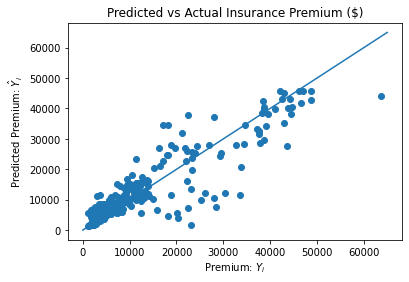

In [ ]:
plt.scatter(y_test, y_pred_knn)
plt.plot(range(65000), range(65000))

plt.xlabel("Premium: $Y_i$")
plt.ylabel("Predicted Premium: $\hat{Y}_i$")
plt.title("Predicted vs Actual Insurance Premium ($)")

plt.show()

In [ ]:
from sklearn import metrics
print('Insurance Premium - K-Nearest Neighbor')
print('Mean Absolute Error (MAE): ${:,}'.format(round(metrics.mean_absolute_error(y_test, y_pred_knn), 2)))
print('Root Mean Squared Error (RMSE): ${:,}'.format(round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_knn)), 2)))

rmse.append(round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_knn)), 2))

Insurance Premium - K-Nearest Neighbor
Mean Absolute Error (MAE): $3,427.84
Root Mean Squared Error (RMSE): $5,471.76


## *Random Forest Regression*
- Bagging/Bootstrapping technique - Random sampling of subset of data reduces bias and variance
- Learning algorithm is limited to a random sample of features of which to search so that the resulting predictions from all of the subtrees have less correlation
- Ensemble method has multiple decision tree models run independently, then output is averaged/aggregated

## Encode categorical data

In [ ]:
# OrdinalEncode 'sex', 'smoker', and 'region' columns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

ct_oerf = ColumnTransformer(transformers=[('encoder1', OrdinalEncoder(), [1,4,5])], remainder='passthrough')
X_ins_tree = np.array(ct_oerf.fit_transform(X_ins))

## Split the Insurance dataset into the Training set and Test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train_tree, X_test_tree, y_train, y_test = train_test_split(X_ins_tree, y, test_size = 0.2, random_state = 42)

## Train the Random Forest Regression model on the Training set

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
rf.fit(X_train_tree, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
from sklearn.model_selection import cross_validate
scores = cross_validate(rf, X_train_tree, y_train,
                        scoring = 'neg_mean_absolute_error', cv = 10,
                        return_train_score = True, 
                        return_estimator = True)

print('On average, the insurance premium prediction from the Random Forest Regression Model is off by ${:,} per person in the Test set.'.format(round(-scores['test_score'].mean(),2)))

off_target.append(round(-scores['test_score'].mean(),0))

On average, the insurance premium prediction from the Random Forest Regression Model is off by $2,832.98 per person in the Test set.


Average off-target deaths is significantly higher with Random Forest compared to with multiple linear regression.

## Predict the Test set Results

In [ ]:
y_pred_rf = rf.predict(X_test_tree)

## Evaluate the Performance

In [ ]:
print("Train score:")
print(round(rf.score(X_train_tree, y_train), 5))

train_score.append(round(rf.score(X_train_tree, y_train), 5))

Train score:
0.97426


In [ ]:
from sklearn.metrics import r2_score
print('R^2:')
print(round(r2_score(y_test, y_pred_rf), 5))

r_square.append(round(r2_score(y_test, y_pred_rf),5))

R^2:
0.86391


Random Forest R^2 is the worst of the three models used to predict COVID-19 deaths using Health factors

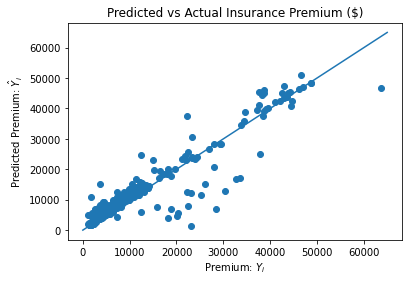

In [ ]:
plt.scatter(y_test, y_pred_rf)
plt.plot(range(65000), range(65000))

plt.xlabel("Premium: $Y_i$")
plt.ylabel("Predicted Premium: $\hat{Y}_i$")
plt.title("Predicted vs Actual Insurance Premium ($)")

plt.show()

## Feature Performance

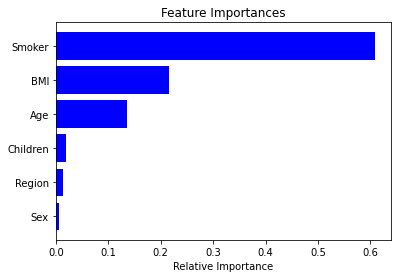

In [ ]:
rf_importances = rf.feature_importances_
indices = np.argsort(rf_importances)
ins_tree = ['Sex', 'Smoker', 'Region', 'Age', 'BMI', 'Children']

plt.title('Feature Importances')
plt.barh(range(len(indices)), rf_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), np.array(ins_tree)[indices])
plt.xlabel('Relative Importance')

plt.show()

The highest Feature Importance by far belongs to 'Smoker' followed by 'BMI' and 'Age'.

In [ ]:
from sklearn import metrics
print('Insurance Premium - Random Forest')
print('Mean Absolute Error (MAE): ${:,}'.format(round(metrics.mean_absolute_error(y_test, y_pred_rf), 2)))
print('Root Mean Squared Error (RMSE): ${:,}'.format(round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)), 2)))

rmse.append(round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)), 2))

Insurance Premium - Random Forest
Mean Absolute Error (MAE): $2,532.08
Root Mean Squared Error (RMSE): $4,596.46


## *XGBoost Regression*
- Builds sequential trees using parallel implementation by switching order of loops (1) to enumerate leaf nodes and (2) to calculate features
- Tree pruning - 'max-depth' parameter defined first then trees 'pruned' to improve computational performance
- Finds optimal split points in weighted datasets
- Built-in regularization via LASSO (L1) or Ridge (L2) to prevent overfitting
- Built-in cross validation

## Train the XGBoost Regression model on the Training set

In [ ]:
# Try the XGBoost model to fit the Health data
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=500, max_depth=2, silent=True)
xgb.fit(X_train_tree, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1, verbosity=1)

In [ ]:
from sklearn.model_selection import cross_validate
scores = cross_validate(xgb, X_train_tree, y_train,
                        scoring = 'neg_mean_absolute_error', cv = 10,
                        return_train_score = True, 
                        return_estimator = True)

print('On average, the insurance premium prediction from the XGBoost Regression Model is off by ${:,} per person in the Test set.'.format(round(-scores['test_score'].mean(),2)))

off_target.append(round(-scores['test_score'].mean(),0))

On average, the insurance premium prediction from the XGBoost Regression Model is off by $2,666.39 per person in the Test set.


## Predict the Test set Results

In [ ]:
y_pred_xgb = xgb.predict(X_test_tree)

## Evaluate the Performance

In [ ]:
print("Train score:")
print(round(xgb.score(X_train_tree, y_train), 5))

train_score.append(round(xgb.score(X_train_tree, y_train), 5))

Train score:
0.90542


In [ ]:
from sklearn.metrics import r2_score
print('R^2:')
print(round(r2_score(y_test, y_pred_xgb), 5))

r_square.append(round(r2_score(y_test, y_pred_xgb),5))

R^2:
0.86883


XGBoost R^2 result drops off compared to multiple linear regression R^2.

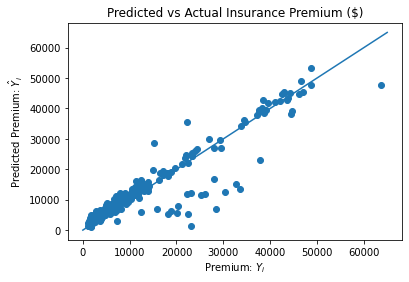

In [ ]:
plt.scatter(y_test, y_pred_xgb)
plt.plot(range(65000), range(65000))

plt.xlabel("Premium: $Y_i$")
plt.ylabel("Predicted Premium: $\hat{Y}_i$")
plt.title("Predicted vs Actual Insurance Premium ($)")

plt.show()

## Feature Performance

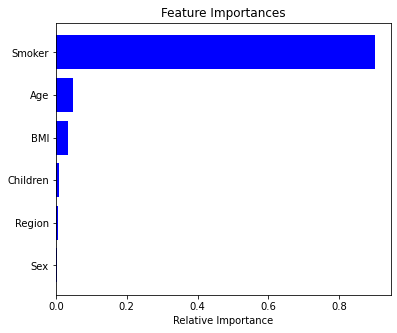

In [ ]:
xgb_importances = xgb.feature_importances_
indices = np.argsort(xgb_importances)

plt.figure(figsize=(6,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), xgb_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), np.array(ins_tree)[indices])
plt.xlabel('Relative Importance')

plt.show()

The highest Feature Importance by far belongs to 'Smoker' followed by 'Age' and 'BMI'.

In [ ]:
from sklearn import metrics
print('Insurance Premium - XGBoost')
print('Mean Absolute Error (MAE): ${:,}'.format(round(metrics.mean_absolute_error(y_test, y_pred_xgb), 2)))
print('Root Mean Squared Error (RMSE): ${:,}'.format(round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb)), 2)))

rmse.append(round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb)), 2))

Insurance Premium - XGBoost
Mean Absolute Error (MAE): $2,453.88
Root Mean Squared Error (RMSE): $4,512.7


## Model Summary

In [ ]:
model = ['Linear Regression-LassoCV', 'K-Nearest Neighbor', 'Random Forest', 'XGBoost']
sum_stats = pd.DataFrame(zip(model, train_score, r_square, off_target, rmse))
sum_stats.columns = ['Insurance Premium Model', 'Train Score', 'Pred vs Actual R^2', 'Avg Premium Off-Target', 'RMSE']
sum_stats = sum_stats.sort_values('Pred vs Actual R^2', ascending=False)
sum_stats = sum_stats.reset_index(drop=True)
sum_stats.index += 1 
sum_stats

,Insurance Premium Model,Train Score,Pred vs Actual R^2,Avg Premium Off-Target,RMSE
1,XGBoost,0.90542,0.86883,2666.0,4512.70
2,Random Forest,0.97426,0.86391,2833.0,4596.46
3,K-Nearest Neighbor,0.85833,0.80715,3337.0,5471.76
4,Linear Regression-LassoCV,0.74143,0.78682,4279.0,5752.87


## Discussion

XGBoost is the best model to predict health insurance premiums. The high R^2 value combined with lowest premium off-target and RMSE gives this model an edge over Random Forest. K-Nearest Neighbor and Multiple Linear Regression are also good but a tier lower. 'Smoker' is the consensus #1 Feature Importance, at least for the models (Linear Regression with LassoCV, Random Forest, XGBoost) that can rank the features. The other features contributing to model prediction are 'Age' and 'BMI'.

## Conclusion

#### **Overall, XGBoost is the best model to predict health insurance premiums followed by Random Forest. 'Smoker' is the critical feature in these tree models. In general, decision tree ensemble models and not Euclidean-distance-based models (KNN, Linear Regression) on Features are the best way to tackle the business objective of this project.**